# Setup

In [29]:
# Standard Imports
import warnings
import pandas as pd
import numpy as np
# Viz
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# from missingpy import KNNImputer
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px

warnings.filterwarnings("ignore")



# Dataset Loading

In [30]:
#Importation du datset
print("Loading dataset...")
df = pd.read_csv("assets/Walmart_Store_sales.csv")

print("...Done.")
pd.set_option('display.max_columns', None)

Loading dataset...
...Done.


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


In [32]:
# Stats basiques
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")

pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


,Missing Records,Percentage (%)
Store,0,0.000000
Date,18,12.000000
Weekly_Sales,14,9.333333
Holiday_Flag,12,8.000000
Temperature,18,12.000000
Fuel_Price,14,9.333333
CPI,12,8.000000
Unemployment,15,10.000000


# Data cleaning

Store - le numéro du magasin
Date - la semaine de vente
Weekly_Sales - ventes pour le magasin donné
Holiday_Flag - indique si la semaine est une semaine de vacances spéciale 1 – Semaine de vacances 0 – Semaine non fériée
Temperature - Température le jour de la vente
Fuel_Price - Coût du carburant dans la région
cpi - Indice des prix à la consommation en vigueur
Unemployement - Taux de chômage dominant

In [33]:
# On supprime les lignes avec des valeurs manquantes sur les dates et sur la variable cible
print("Droping Nan values...")
df = df.dropna(subset="Weekly_Sales")
df = df.dropna(subset="Date")
print()
print('Done...')

Droping Nan values...

Done...


In [34]:
# Supression des outliers Nous supprimons les lignes contenant des valeurs invalides ou des valeurs aberrantes. Seront considérées comme des valeurs aberrantes toutes les caractéristiques numériques qui n'appartiennent pas à l'intervalle : [X¯−3σ,X¯+3σ] . Cela concerne les colonnes : Temperature, Fuel_price, CPI et Unemployment
for i in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
  df = df[~(np.abs(df[i]-df[i].mean()) > (3*df[i].std()))]

In [35]:
# Imputation de la medianne sur les valeurs manquantes sur les features 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'

to_median = ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
df[to_median] = df[to_median].fillna(df[to_median].mean())

In [36]:
print("Percentage of missing values: ")
print(df.shape)
pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Percentage of missing values: 
(113, 8)


,Missing Records,Percentage (%)
Store,0,0.0
Date,0,0.0
Weekly_Sales,0,0.0
Holiday_Flag,0,0.0
Temperature,0,0.0
Fuel_Price,0,0.0
CPI,0,0.0
Unemployment,0,0.0


In [37]:
# On décompose les horaires pour une meilleur traitement de données

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year


In [38]:
df.sample(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day,month,year
121,5.0,2011-07-29,275142.17,0.0,89.42,3.682,216.046436,6.529,29,7,2011
49,16.0,2012-03-30,485095.41,0.0,48.29,3.750,197.413326,6.162,30,3,2012
132,4.0,2011-07-22,2036231.39,0.0,82.84,3.627,129.150774,5.644,22,7,2011
105,19.0,2010-07-30,1366395.96,0.0,72.83,2.932,132.598387,8.099,30,7,2010
100,3.0,2010-06-18,364076.85,0.0,83.52,2.637,214.785826,7.343,18,6,2010


# Data Visualization

In [39]:

fig = px.histogram(df, x='Date', y='Weekly_Sales', color='year', nbins=50)
fig.show()

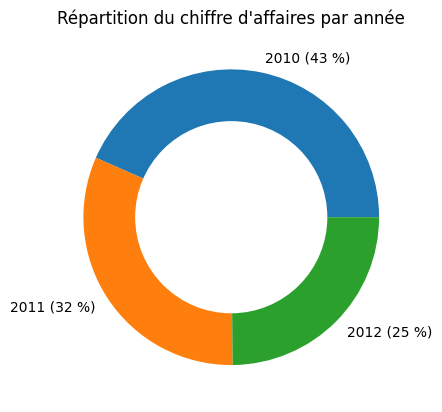

In [40]:
ca_per_year = df.groupby(['year'])[['Weekly_Sales']].sum()

ca_per_year.rename({'Weekly_Sales' : 'annual_turn_over'}, axis=1, inplace=True)
ca_per_year['(%)'] = [str(round(100 * x / ca_per_year.annual_turn_over.sum())) for x in ca_per_year.annual_turn_over]
ca_per_year = ca_per_year.reset_index().astype('str')
ca_per_year['(%)'] = ca_per_year.year + ' (' + ca_per_year['(%)'] + ' %)'

#Plotting pie chart
ax = plt.pie(ca_per_year.annual_turn_over,labels=ca_per_year['(%)']  )
centre_circle = plt.Circle((0,0),0.65,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title("Répartition du chiffre d'affaires par année")
plt.show()

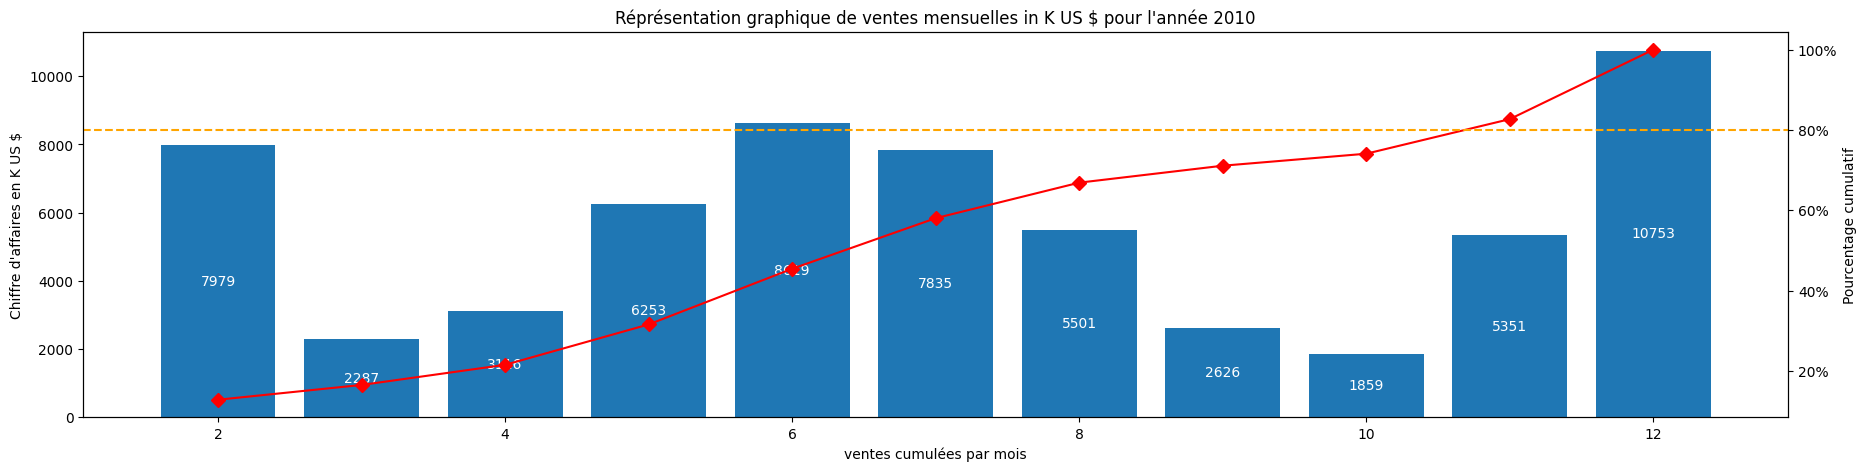

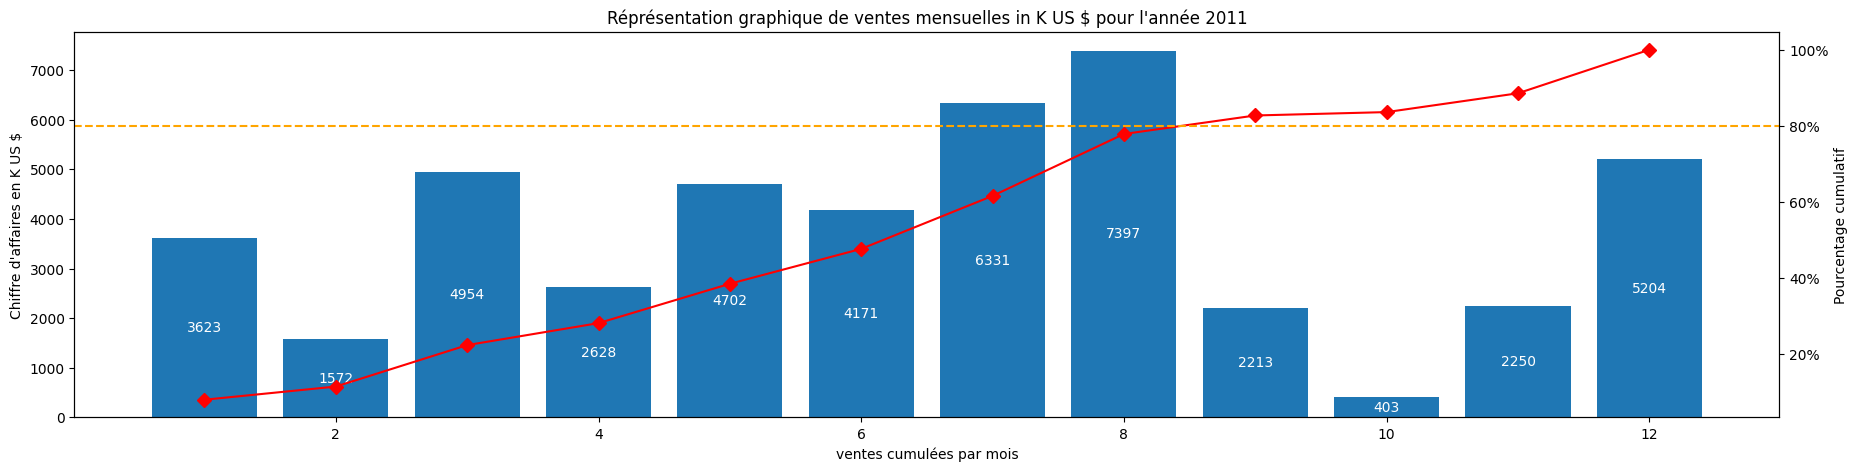

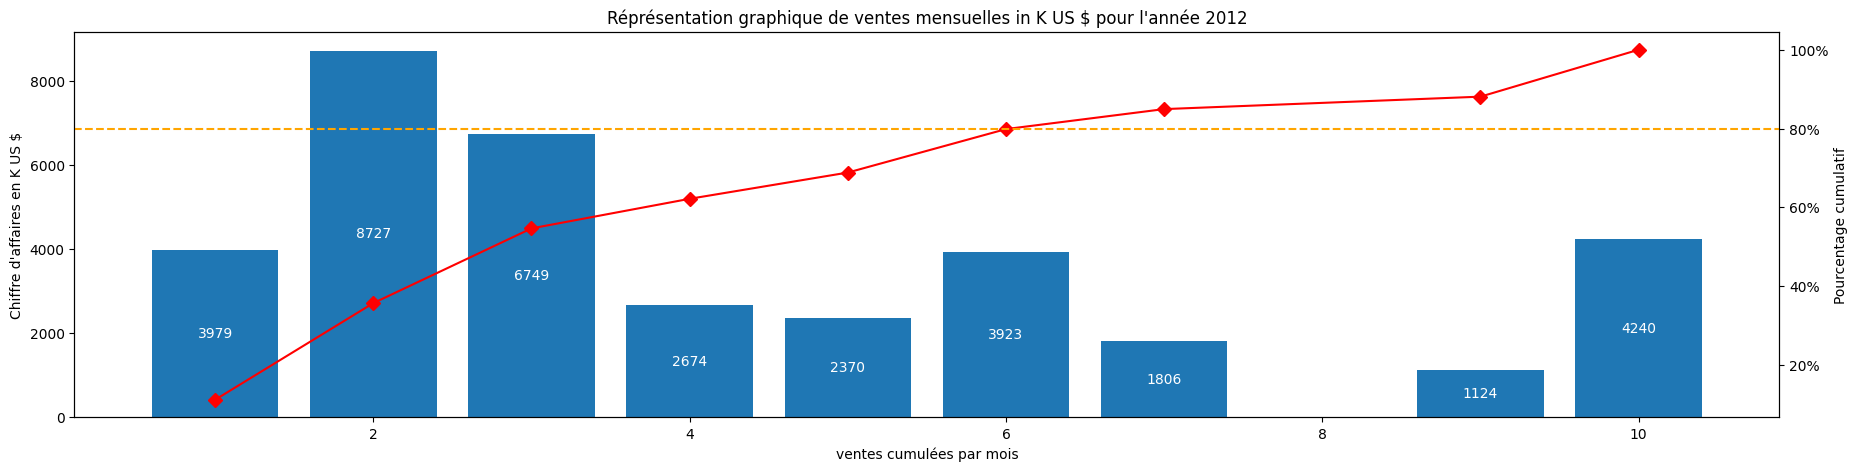

In [41]:
def pareto_graph(year):
  df_year =  df[df.year == year].sort_values(by=['month']).groupby(['month'])['Weekly_Sales'].sum().to_frame()
  df_year.Weekly_Sales =[round(x / 1000) for x in df_year.Weekly_Sales]
  df_year["cum_percentage"] = round(df_year["Weekly_Sales"].cumsum()/df_year["Weekly_Sales"].sum()*100,2)
  
  fig, ax = plt.subplots(figsize=(22,5))

  # Plot bars (i.e. frequencies)
  ax.bar(df_year.index, df_year["Weekly_Sales"])
  ax.set_title("Réprésentation graphique de ventes mensuelles in K US $ pour l'année {}".format(year))
  ax.set_xlabel("ventes cumulées par mois")
  ax.set_ylabel("Chiffre d'affaires en K US $")

  # Second y axis (i.e. cumulative percentage)
  ax2 = ax.twinx()
  ax2.plot(df_year.index, df_year["cum_percentage"], color="red", marker="D", ms=7)
  ax2.axhline(80, color="orange", linestyle="dashed")
  ax2.yaxis.set_major_formatter(PercentFormatter())
  ax2.set_ylabel("Pourcentage cumulatif")

  for c in ax.containers:
    ax.bar_label(c, label_type='center', color="white")
  plt.show()

for year in list(set(df.year)):
  pareto_graph(year) 

On constate que les ventes se sont dégradées progressisvement de 2010 à 2012.

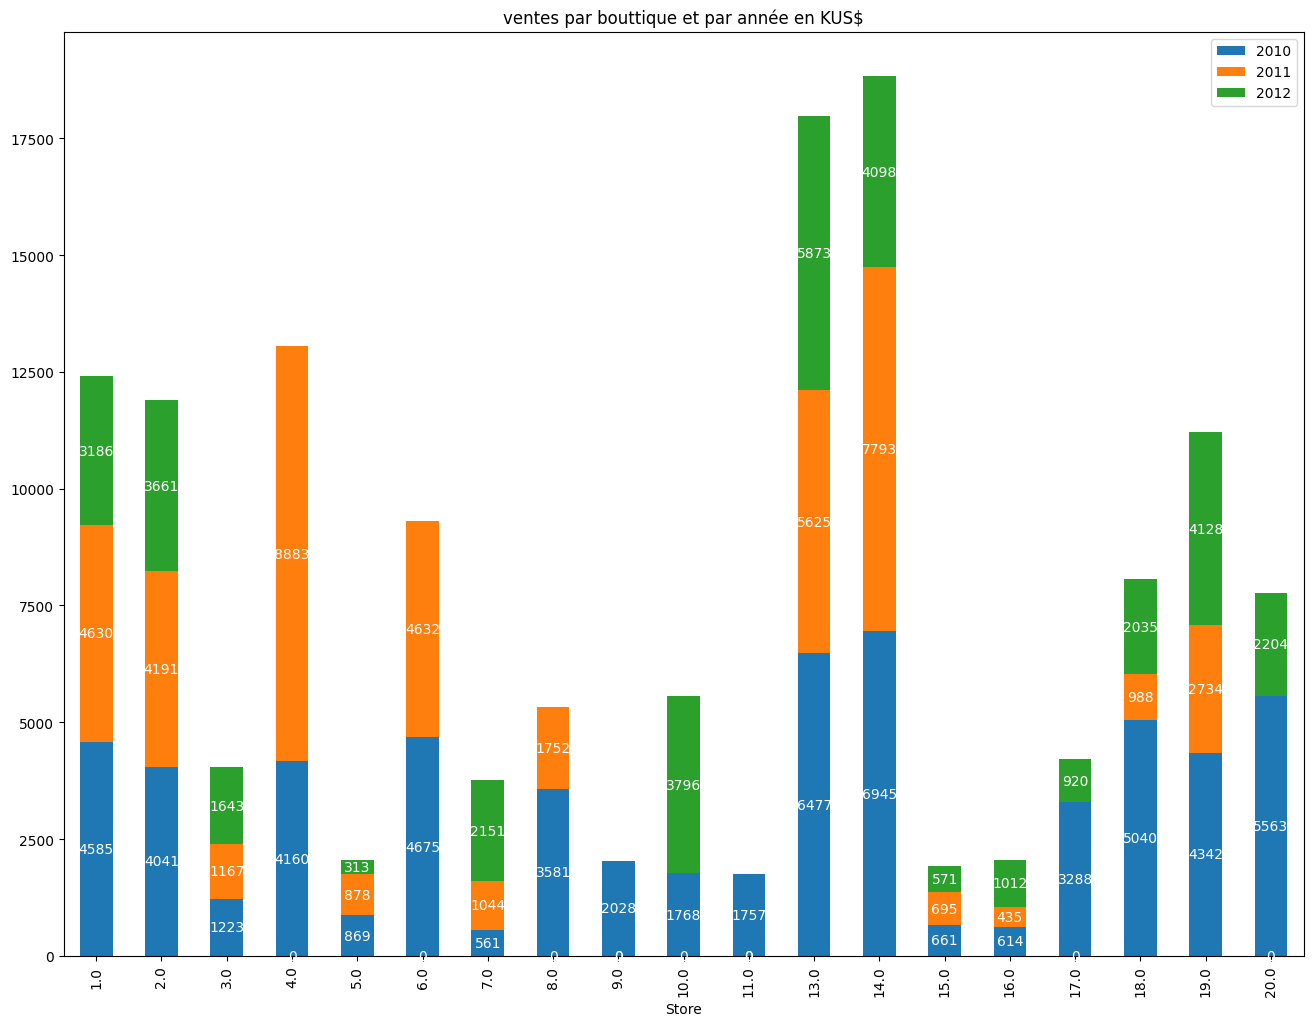

In [42]:
#Plotting turn-over by year and by store

ax = df.groupby([df.Store, df.year])['Weekly_Sales'].agg('sum').mul(0.001).unstack().sort_index().apply(lambda x : round(x)).plot(kind='bar',stacked=True, figsize=(16,12))
for c in ax.containers:
    ax.bar_label(c, label_type='center', color = 'white' )
plt.legend(loc='best')
plt.title('ventes par bouttique et par année en KUS$')
plt.show()

Les magasins qui ont perfomé entre 2010 et 2012 les mieux le 13 et le 14.

# Preprocessing and Modeling

<Axes: >

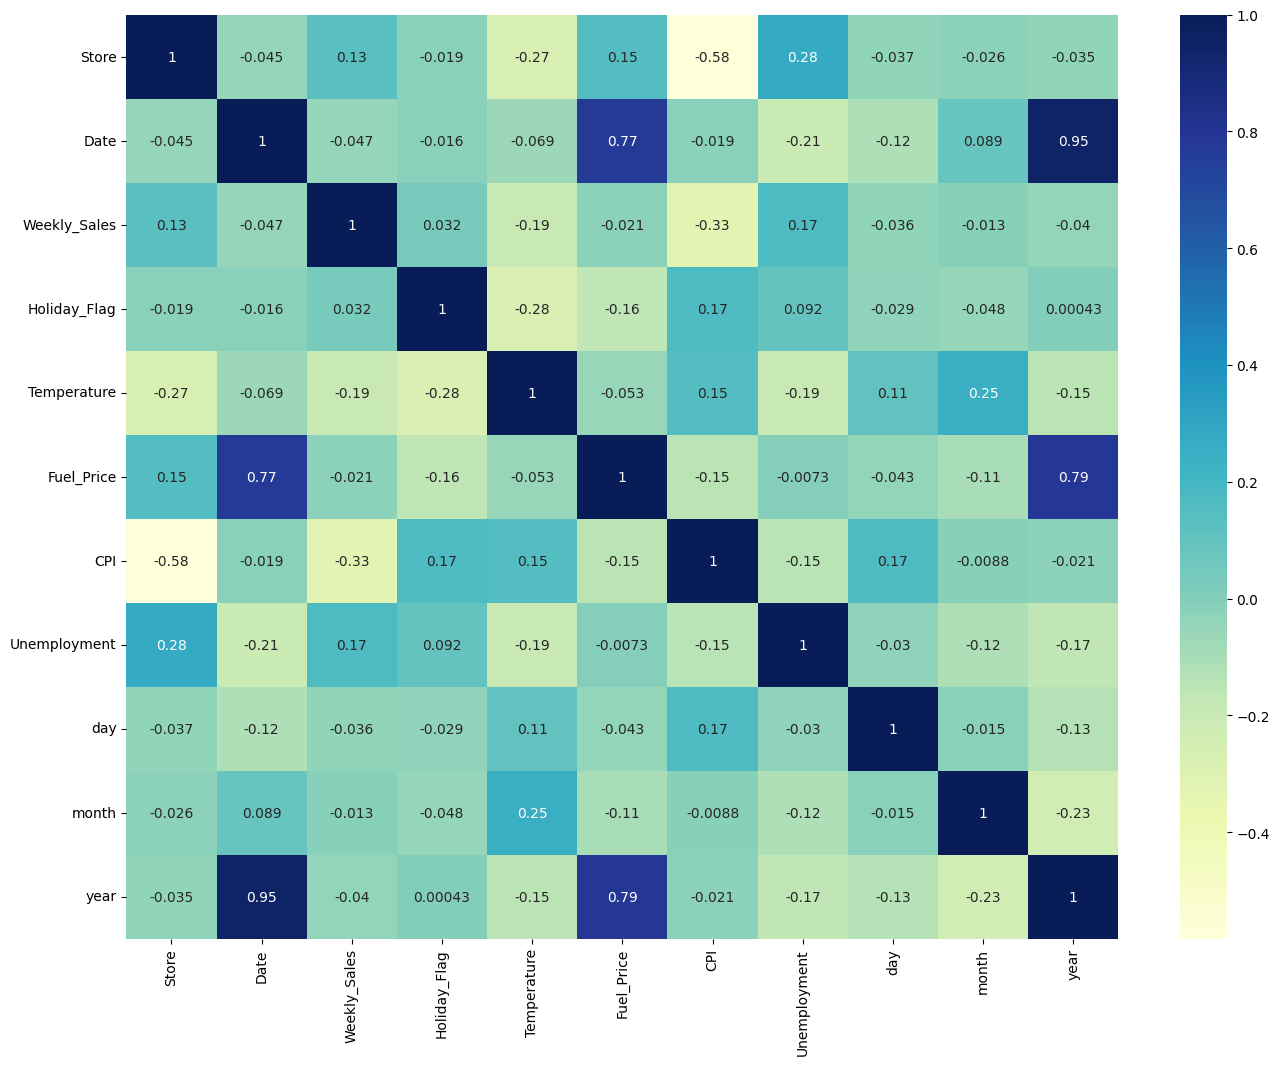

In [43]:
# Plotting a matrix correlation of features
corr = df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, annot=True, cmap='YlGnBu')

In [44]:
target_name = 'Weekly_Sales'

Y = df[:][target_name]
X = df.drop(columns= [target_name, 'Date'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [45]:
# Create pipeline for numeric features
numeric_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "year", "month", "day"]
numeric_transformer = Pipeline(steps=[
    # missing values will be replaced by columns' median
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = ["Store", "Holiday_Flag"]
categorical_transformer = Pipeline(
    steps=[
        # missing values will be replaced by most frequent value
        ('imputer', SimpleImputer(strategy='most_frequent')),
        # first column will be dropped to avoid creating correlations between features
        ('encoder', OneHotEncoder(drop='first'))
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train)  # Preprocessing influenceur
X_test = preprocessor.transform(X_test)  # Preprocessing copieur

print(f'numeric_features : {numeric_features}')
print(f'categorical_features : {categorical_features}')

numeric_features : ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day']
categorical_features : ['Store', 'Holiday_Flag']


## Modeling

In [46]:
# Definition des models

lin_model = LinearRegression()
xgb_reg_model = xgb.XGBRegressor(use_label_encoder=False, eval_metric='rmse')
rf_reg_model = RandomForestRegressor(n_jobs=-1, max_depth=4, random_state=0)
knn_reg_model = KNeighborsRegressor(n_neighbors=5)
tree_dec_reg_model = DecisionTreeRegressor()
lasso_model = Lasso()
ridge_model = Ridge(max_iter=10000)

In [47]:
# Boucle à travers les modèles et effectue l'entraînement et l'évaluation
for reg in [lin_model, xgb_reg_model, rf_reg_model, knn_reg_model, tree_dec_reg_model]:
    reg.fit(X_train, Y_train)  # Entraîne le modèle sur les données d'entraînement
    y_reg_pred = reg.predict(X_test)  # Fait des prédictions sur les données de test
    mse = mean_squared_error(Y_test, y_reg_pred)  # Calcule l'erreur quadratique moyenne
    rmse = np.sqrt(mse)  # Calcule la racine carrée de l'erreur quadratique moyenne pour obtenir le RMSE
    r2 = r2_score(Y_test, y_reg_pred)  # Calcule le score R2
    mae = mean_absolute_error(Y_test, y_reg_pred)  # Calcule l'erreur absolue moyenne
    explained_var = explained_variance_score(Y_test, y_reg_pred)  # Calcule le score de variance expliquée
   
    
    # Affiche les métriques d'évaluation pour chaque modèle
    print(f"{reg.__class__.__name__} RMSE: {rmse:.2f}")
    print(f"{reg.__class__.__name__} R2 Score: {r2:.2f}")
    print(f"{reg.__class__.__name__} MAE: {mae:.2f}")
    print(f"{reg.__class__.__name__} Explained Variance Score: {explained_var:.2f}")
    print()

LinearRegression RMSE: 171350.15
LinearRegression R2 Score: 0.94
LinearRegression MAE: 126706.09
LinearRegression Explained Variance Score: 0.94

XGBRegressor RMSE: 221863.11
XGBRegressor R2 Score: 0.90
XGBRegressor MAE: 151392.13
XGBRegressor Explained Variance Score: 0.90

RandomForestRegressor RMSE: 392460.04
RandomForestRegressor R2 Score: 0.68
RandomForestRegressor MAE: 349509.06
RandomForestRegressor Explained Variance Score: 0.68

KNeighborsRegressor RMSE: 520955.99
KNeighborsRegressor R2 Score: 0.43
KNeighborsRegressor MAE: 454999.42
KNeighborsRegressor Explained Variance Score: 0.43

DecisionTreeRegressor RMSE: 128045.25
DecisionTreeRegressor R2 Score: 0.97
DecisionTreeRegressor MAE: 96347.83
DecisionTreeRegressor Explained Variance Score: 0.97



Notre modèle DecisionTreeRegressor semble être le modèle le plus performant pour prédire les ventes hebdomadaires de Walmart. Cependant, notons que les arbres de décision peuvent facilement sur-ajuster (ovrefitting) les données, il serait donc important de valider ce modèle sur un ensemble de test indépendant ou d'utiliser des techniques de validation croisée.

In [48]:
# Entraîner le modèle
tree_dec_reg_model.fit(X, Y)

# Obtenir les importances des caractéristiques
importances = tree_dec_reg_model.feature_importances_

# Créer un DataFrame pour visualiser les importances des caractéristiques
importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Trier le DataFrame par importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Afficher le DataFrame
print(importances_df)


        Feature  Importance
0         Store    0.640347
4           CPI    0.220723
7         month    0.095464
2   Temperature    0.022131
1  Holiday_Flag    0.011289
3    Fuel_Price    0.005212
6           day    0.002468
5  Unemployment    0.002174
8          year    0.000192


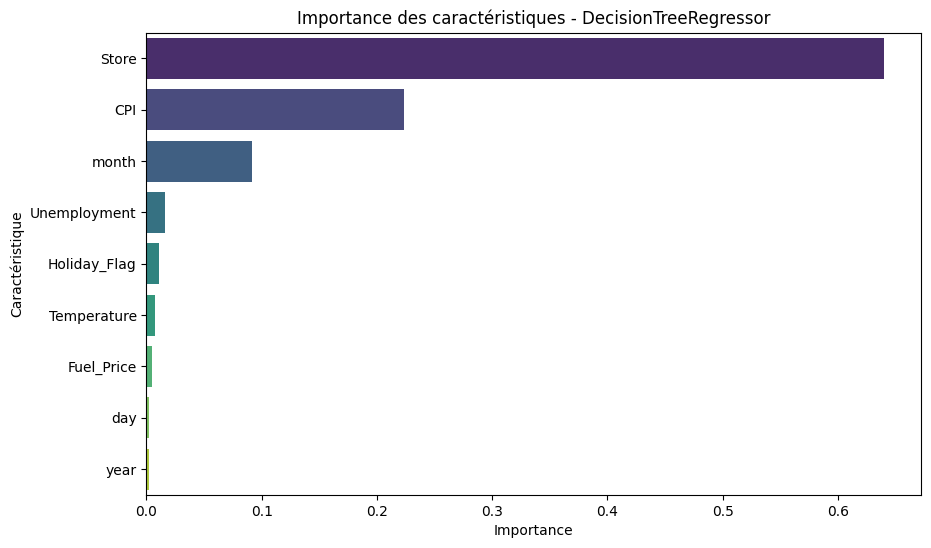

In [49]:
tree_dec_reg_model.fit(X, Y)

importances = tree_dec_reg_model.feature_importances_

importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})


importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importances_df, palette='viridis')


plt.title('Importance des caractéristiques - DecisionTreeRegressor')
plt.xlabel('Importance')
plt.ylabel('Caractéristique')

# Afficher le graphique
plt.show()


On voit par ce graphique que la variable qui a le plus influencé notre model est la feature 'Store', qui represente un des magasins lambda de Walmart.

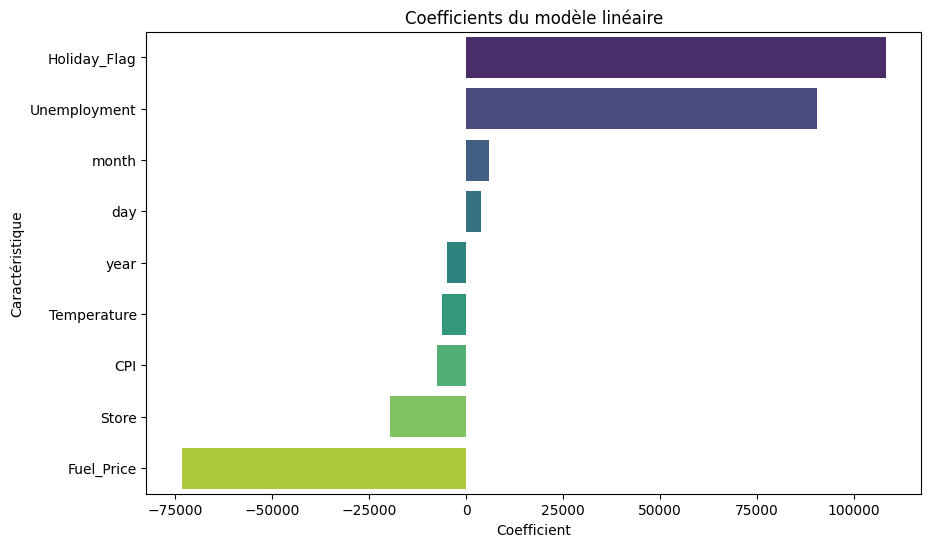

In [50]:


lin_model.fit(X, Y)

# Obtenir les coefficients du modèle linéaire
coefs = lin_model.coef_

# Créer un DataFrame pour visualiser les coefficients
coefs_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefs
})

# Trier le DataFrame par coefficient
coefs_df = coefs_df.sort_values(by='Coefficient', ascending=False)

# Créer le graphique
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coefs_df, palette='viridis')

# Ajouter le titre et les labels d'axe
plt.title('Coefficients du modèle linéaire')
plt.xlabel('Coefficient')
plt.ylabel('Caractéristique')

# Afficher le graphique
plt.show()


### Ridge Model

In [51]:
params = {'alpha':[0.01, 0.02, 0.05, 0.1, 0.5, 1, 10]}

gridsearch = GridSearchCV(ridge_model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 0.02}
Best validation accuracy :  0.914671485532516


In [55]:
ridge_model = Ridge(alpha=0.02)
ridge_model.fit(X_train, Y_train)

y_train_pred = ridge_model.predict(X_train)
Y_test_pred = ridge_model.predict(X_test)

print("r2-score on train set : ", r2_score(Y_train, y_train_pred))
print("r2-score on test set : ", r2_score(Y_test, Y_test_pred))
print("Standard deviation on train set :", cross_val_score(ridge_model, X_train, Y_train, cv=10, scoring='r2').std())

r2-score on train set :  0.972642910538535
r2-score on test set :  0.9452331065056636
Standard deviation on train set : 0.08294365076364961


### Lasso Model

In [56]:
params = {'alpha':[0.1, 1, 10,100,500,1000]}

gridsearch = GridSearchCV(lasso_model, param_grid = params, cv = 10,scoring='r2') 
gridsearch.fit(X_train, Y_train)
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'alpha': 1000}
Best validation accuracy :  0.9197286647555346


In [54]:
lasso_model = Lasso(alpha=1000)
lasso_model.fit(X_train, Y_train)

y_train_pred = lasso_model.predict(X_train)
Y_test_pred = lasso_model.predict(X_test)

print("r2-score on train set : ", r2_score(Y_train, y_train_pred))
print("r2-score on test set : ", r2_score(Y_test, Y_test_pred))
print("Standard deviation on train set :", cross_val_score(lasso_model, X_train, Y_train, cv=10, scoring='r2').std())

r2-score on train set :  0.9722173233944769
r2-score on test set :  0.9494695822148516
Standard deviation on train set : 0.07509336130269136
